# A Framework for Comparing and Selecting from Several Segmentation Methods in Absence of Ground Truth labels
## Zachary Sims, Luke Strgar, Robert Heussner, Dharani Thirumalaisamy, Guillaume Thibault, Young Hwan Chang


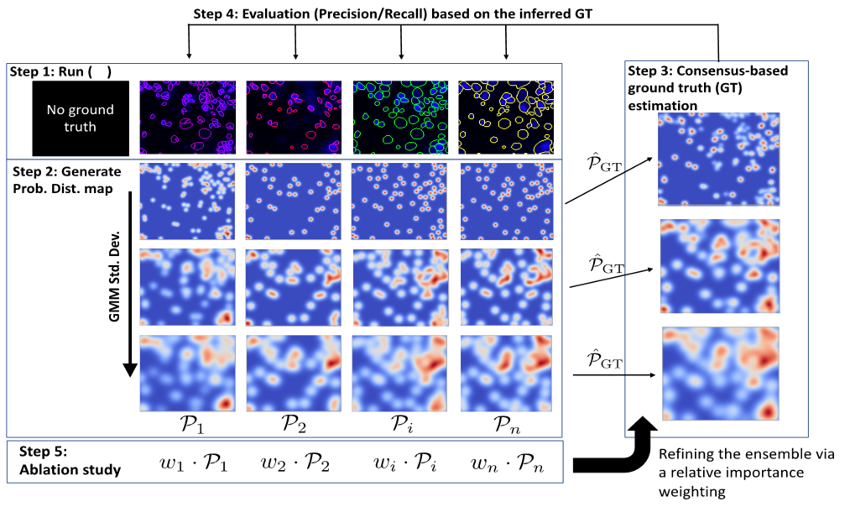Cell segmentation is a critical step in any multiplexed tissue imaging data analysis pipeline. Accurate segmentation masks are key to a number of downstream tasks in the realm of single-cell analysis, and as a result a number of competing methods have emerged. This notebook demonstrates a method for evaluating the performance of these models when there is no ground truth labels.

In [1]:
from argparse import ArgumentParser
import yaml
import numpy as np
from skimage.io import imread, imshow, imsave
from skimage.morphology import binary_dilation, disk
from skimage.measure import regionprops, label
import os
import copy
from glob import glob
import pickle
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
import pandas as pd

In [2]:
methods = ["mesmer", "stardist", "maskrcnn", "cellpose", "unet", "unmicst"]
radii = [2, 4, 6, 8, 10, 12, 14, 16]
colors = ["purple", "red", "green", "gold", "pink","blue"]
datapath = "example_data"
results_dir = "test_results"
num_agree = 4

Sample IDs are derived from the filenames in each method directory, and the IDs should correspond to eachother

In [3]:
sample_ids = [s.split(".")[0] for s in os.listdir(os.path.join(datapath, methods[0]))]

`datapath` is the path to a directory containing subdirectories for each segmentation method. Each subdirectory contains the segmentation masks for the 88 cores in the TMA dataset produced by the method.

below the segmentation maps of multiple methods can be viewed on a single TMA core:

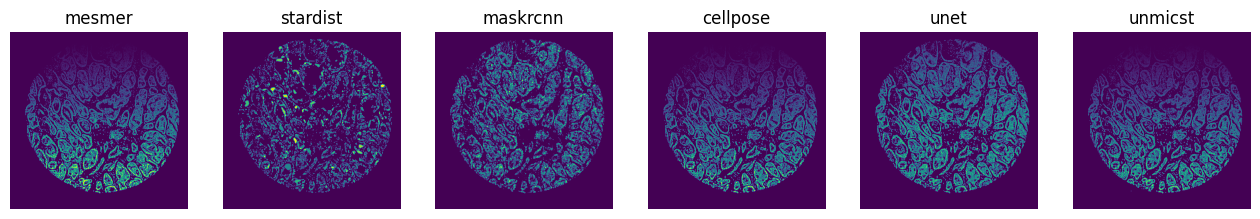

In [4]:
fig, ax  = plt.subplots(1,len(methods), figsize=(16,16))

for ax, method in zip(fig.axes, methods):
    try:
        im = imread(os.path.join(datapath, method, f'{sample_ids[0]}.tif'))
    except:
        im = imread(os.path.join(datapath, method, f'{sample_ids[0]}.png'))
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(f'{method}')

plt.show()

It will be better to visualize just a small section of the masks:

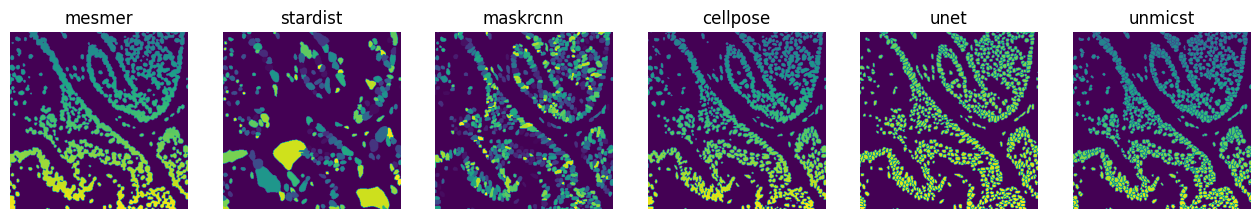

In [5]:
fig, ax  = plt.subplots(1,len(methods), figsize=(16,16))

for ax, method in zip(fig.axes, methods):
    im = imread(os.path.join(datapath, method, f'{sample_ids[0]}.tif'))
    ax.imshow(im[600:1000, 600:1000])
    ax.axis('off')
    ax.set_title(f'{method}')
    
plt.show()

# 1.) Create Probability Masks

The first step is to create probability masks representing the probability that a pixel is classified as a cell in each of the segmentation methods. We want to create a seperate mask for each radius in our set of radii, so for each radius size, we set the value of each cell centroid to 1 and zero out the remaining image, then we expand the centroids to have the desired radius.

In [6]:
def getid(samp_path):
    return samp_path.split("/")[-1].split(".")[0]


def create_pmask(segpath, r):
    """converts a standard segmentation mask into one with a dilated area around 
    the center of the original mask"""
    seg = imread(segpath)
    mask = np.zeros_like(seg)
    rps = regionprops(seg)
    
    #get center of each cell and set the value to one
    centroids = np.array(
        list(map(lambda x : np.array(x.centroid).astype(int), rps))
    )
    mask[centroids[:,0], centroids[:,1]] = 1
    
    #dilate around the center of the cell with the radius size and binarize the mask
    mask = binary_dilation(mask, disk(r))
    
    return mask


def compute_masks(sid, radii, methods, datapath):
    """gets all probability masks (all radii sizes X all segmentation methods) for a single sample
    return a dictionary containing a dictionary for each radii size, which containins the pmask 
    for each segmentation method plus the average of all the masks across methods"""
    masks = {}
    for r in radii: #for each radius size
        rmasks = {}
        
        for m in methods:#for each segmentation method
            segpath = glob(os.path.join(datapath, m, sid + "*"))[0]
            pmask = create_pmask(segpath, r) #create pmask
            rmasks[m] = pmask
            
        #get average pmask of all methods for a single radius
        stack = np.stack(list(rmasks.values()))
        avg_mask = stack.mean(0) 
        rmasks["mean"] = avg_mask
        
        #save masks from each method with radius
        masks[r] = rmasks
        
    return masks 


def write_pmasks(sample_ids, radii, methods, datapath, save_dir):
    """main function to create and save probability masks"""
    print(f"Writing probability masks for {len(sample_ids)} samples")
    
    for sid in tqdm(sample_ids):
        #save path for sample
        save_path = os.path.join(save_dir, f"{sid}.pkl")
        #dont recreate files
        if os.path.exists(save_path):
            continue

        #get masks for sample
        sid_masks = compute_masks(sid, radii, methods, datapath)
        with open(save_path, "wb") as handle:
            pickle.dump(sid_masks, handle)
            
    print(f"Proability masks saved to {save_dir}")

In [7]:
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
pmask_save_dir = os.path.join(results_dir, "pmasks")
if not os.path.exists(pmask_save_dir):
    os.makedirs(pmask_save_dir)

In [8]:
write_pmasks(sample_ids, radii, methods, datapath, pmask_save_dir)

Writing probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:27<00:00, 87.95s/it]

Proability masks saved to test_results/pmasks


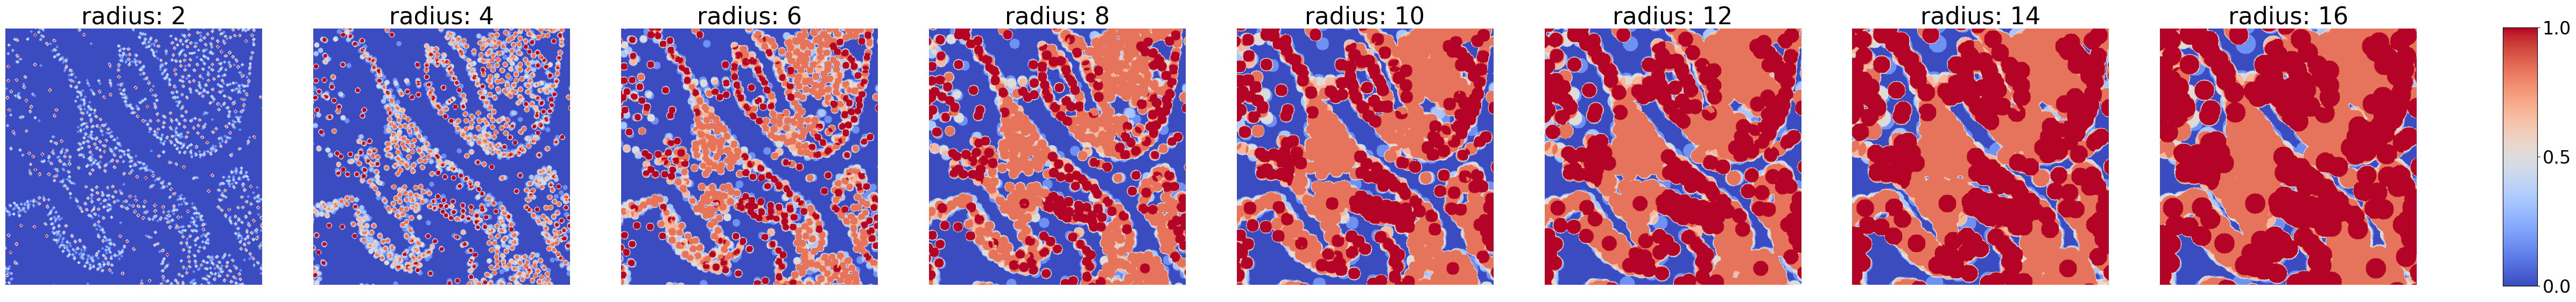

In [9]:
fig, ax  = plt.subplots(1,8, figsize=(32,32))
with open(os.path.join(pmask_save_dir, f'{sample_ids[0]}.pkl'), "rb") as handle:
    h = pickle.load(handle)
for radius, ax in zip(radii, fig.axes):
    im = ax.imshow(h[radius]['mean'][600:1000, 600:1000], cmap='coolwarm')
    ax.axis('off')
    ax.set_title(f'radius: {radius}', fontsize=32)
plt.subplots_adjust(-0.5)
cbar_ax = fig.add_axes([0.95, 0.42, 0.02, 0.15])
cb = fig.colorbar(im, orientation='vertical', cax=cbar_ax, shrink=0.1, ticks=[0, 0.5, 1])
cb.ax.tick_params(labelsize=24)
plt.show()

# 2.) Filter masks to only include regions of the probability mask that were captured by _min_num_agree_ segmention methods

In [10]:
def filter_mask(mask, avg_labs):
    """filter probability mask for a single method (mask) using the thresholded, averaged, proability mask"""
    #copy 
    filtered = copy.deepcopy(mask)
    mask_lab = label(mask)
    rps = regionprops(mask_lab)
    
    for rp in rps: #for each cell region
        #get cell center coordinates from single-method mask
        coords = rp.coords
        #use those coords to get values of averaged mask 
        vals = avg_labs[coords[:,0], coords[:,1]]
        uniq, counts = np.unique(vals, return_counts=True)
        
        #ignore background
        if uniq[0] == 0:
            uniq = uniq[1:]
            counts = counts[1:]
            
        n_unique = len(uniq)
        
        #if more than 1 value, zero out pixels in mask that do not equal the most common value
        if n_unique > 1:
            amax = np.argmax(counts)
            top_val = uniq[amax]
            idxs = np.where(vals != top_val)
            to_zero = coords[idxs,:][0]
            filtered[to_zero[:,0], to_zero[:,1]] = False
            
    return filtered


def filter_pmasks(sample_ids, pmask_save_dir, filtered_save_dir, min_num_agree, methods):
    print(f"Filtering probability masks for {len(sample_ids)} samples")
    
    for sid in tqdm(sample_ids):#for each sample
        #open pickle file containing probability masks
        with open(os.path.join(pmask_save_dir, f"{sid}.pkl"), "rb") as handle:
            data = pickle.load(handle)

        filtered_masks = {}
        #filter averaged probability masks
        for r, masks in data.items():#for each radius, set of probability masks
            avg = masks["mean"]
            #threshold average mask to only keep pixels labeled by at least min_num_agree seg. methods
            avg_threshd = (avg >= (min_num_agree / len(methods)))
            avg_labs = label(avg_threshd)

            r_filtered_masks = {}
            for m in methods:# for each probability method
                #use thresholded, averaged probability mask
                r_filtered_masks[m] = filter_mask(masks[m], avg_labs)

            #get new average mask
            new_stack = np.stack(list(r_filtered_masks.values()))        
            new_avg = new_stack.mean(0)
            r_filtered_masks["mean"] = new_avg
            filtered_masks[r] = r_filtered_masks
            
        #save new probability masks
        if os.path.exists(os.path.join(filtered_save_dir, f"{sid}.pkl")): continue
        with open(os.path.join(filtered_save_dir, f"{sid}.pkl"), "wb") as handle:
            pickle.dump(filtered_masks, handle)
            
    print(f"Filtered probability masks saved to {filtered_save_dir}")

In [11]:
filtered_pmask_save_dir = os.path.join(results_dir, "filtered_pmasks")
if not os.path.exists(filtered_pmask_save_dir):
    os.makedirs(filtered_pmask_save_dir)

In [12]:
filter_pmasks(sample_ids, pmask_save_dir, filtered_pmask_save_dir, num_agree, methods)

Filtering probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.15s/it]

Filtered probability masks saved to test_results/filtered_pmasks


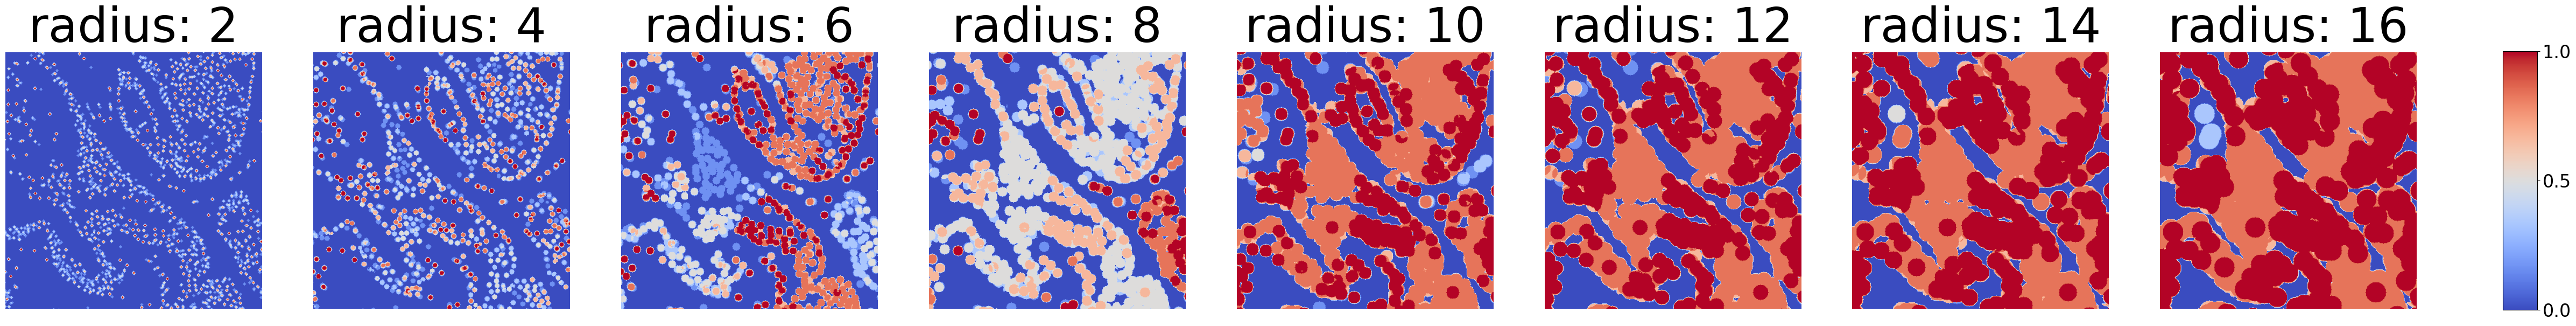

In [13]:
fig, ax  = plt.subplots(1,8, figsize=(32,32))
with open(os.path.join(filtered_pmask_save_dir, f'{sample_ids[0]}.pkl'), "rb") as handle:
    h = pickle.load(handle)
for radius, ax in zip(radii, fig.axes):
    ax.imshow(h[radius]['mean'][600:1000, 600:1000], cmap='coolwarm')
    ax.axis('off')
    ax.set_title(f'radius: {radius}', fontsize=64)
plt.subplots_adjust(-0.5)
cbar_ax = fig.add_axes([0.95, 0.42, 0.02, 0.15])
cb = fig.colorbar(im, orientation='vertical', cax=cbar_ax, shrink=0.1, ticks=[0, 0.5, 1])
cb.ax.tick_params(labelsize=24)
plt.show()

# 3.) Initial Evaluation

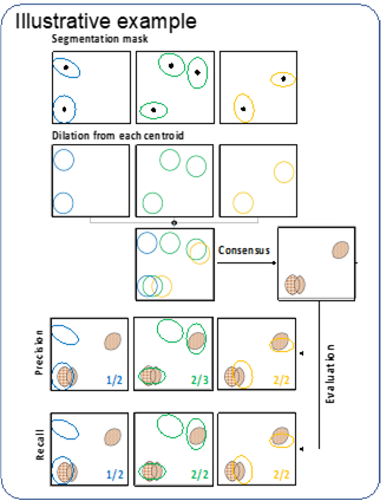
Calculate precision and recall based off refined probability masks

In [14]:
def eval_mask(gt, m):
    """returns precision and recall for a pair of masks, see diagram above"""
    rps = regionprops(m)
    coords = list(map(lambda x : x.coords, rps))
    correct = 0
    
    for c in coords:
        correct += (gt[c[:,0], c[:,1]]).max()
    precision = correct / len(rps)
    
    gt_labs = label(gt)
    gt_rps = regionprops(gt_labs)
    coords = list(map(lambda x : x.coords, gt_rps))
    correct = 0
    
    for c in coords:
        correct += (m[c[:,0], c[:,1]]).max() > 0
    recall = correct / len(gt_rps)
    
    assert precision <= 1
    assert precision >= 0
    assert recall <= 1
    assert recall >= 0
    
    return precision, recall


def evaluate_masks(sample_ids, filtered_pmask_save_dir, radii, min_num_agree, num_methods):
    precision = {}
    recall = {}
    print(f"Computing precision and recall for {len(sample_ids)} samples")
    for sid in tqdm(sample_ids):
        data_load_path = os.path.join(filtered_pmask_save_dir, f"{sid}.pkl")
        with open(data_load_path, "rb") as handle:
            data = pickle.load(handle)

        sid_precisions = {r:{} for r in radii}
        sid_recalls = {r:{} for r in radii}

        for r, masks in data.items():

            avg = masks["mean"]
            avg_thresh = (avg >= (min_num_agree / num_methods))
            
            for name, mask in masks.items():
                if name == "mean":
                    continue
                labd_mask = label(mask)
                prec, rec = eval_mask(avg_thresh, labd_mask)
                sid_precisions[r][name] = prec
                sid_recalls[r][name] = rec

        precision[sid] = sid_precisions
        recall[sid] = sid_recalls

    return precision, recall

In [15]:
precision, recall = evaluate_masks(sample_ids, filtered_pmask_save_dir, radii, num_agree, len(methods))

Computing precision and recall for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.83s/it]


In [16]:
def plot_precision_recall(precision, recall, methods, sample_ids):
    points = {m:[] for m in methods}

    for sid in sample_ids:
        for i, rad in enumerate(radii):
            for m in methods:
                p = precision[sid][rad][m]
                r = recall[sid][rad][m]
                points[m].append((r, p))

    fig, ax = plt.subplots(1, len(methods), figsize=(20,2))
    fig.text(0.5, -0.1, 'precision', ha='center', va='center')
    fig.text(0.1, 0.5, 'recall', ha='center', va='center', rotation='vertical')
    for method, a in zip(methods, fig.axes):
        a.set_xlim(0.3, 1)
        a.set_ylim(0.5, 1)
        a.set_title(method)

        xs = [x for x,y in points[method]]
        ys = [y for x,y in points[method]]

        sns.kdeplot(x=xs, y=ys, clip=(0,1), ax=a)
        a.scatter(xs, ys)
    plt.show()

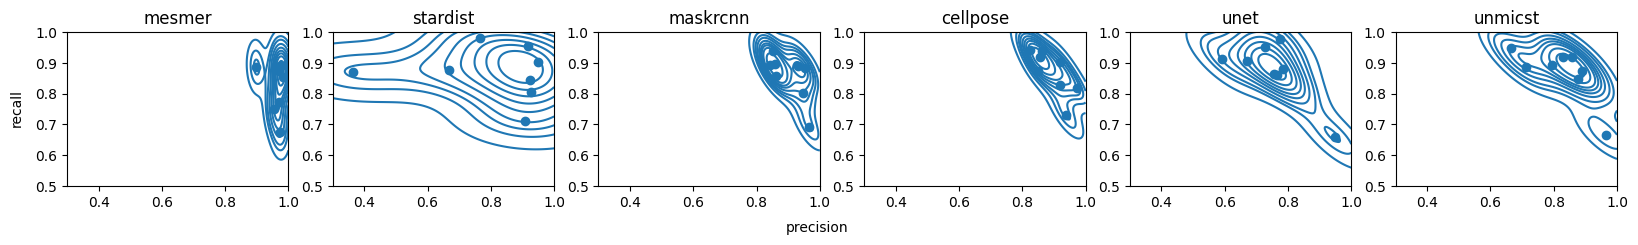

In [17]:
plot_precision_recall(precision, recall, methods, sample_ids)

# 4.) Ablate Probability Masks to obtain importance weights for each method

In [18]:
#write new pmasks for each witheld method
for method in methods:
    pmask_save_dir = os.path.join(results_dir, f"pmasks_{method}_out")
    if not os.path.exists(pmask_save_dir):
        os.makedirs(pmask_save_dir)
    methods_ = [m for m in methods if m != method]
    write_pmasks(sample_ids, radii, methods_, datapath, pmask_save_dir)

Writing probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:14<00:00, 74.62s/it]


Proability masks saved to test_results/pmasks_mesmer_out
Writing probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:15<00:00, 75.23s/it]


Proability masks saved to test_results/pmasks_stardist_out
Writing probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:10<00:00, 70.36s/it]


Proability masks saved to test_results/pmasks_maskrcnn_out
Writing probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:11<00:00, 71.68s/it]


Proability masks saved to test_results/pmasks_cellpose_out
Writing probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:13<00:00, 73.15s/it]


Proability masks saved to test_results/pmasks_unet_out
Writing probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:12<00:00, 72.36s/it]

Proability masks saved to test_results/pmasks_unmicst_out


In [ ]:
#write new filtered pmasks for each witheld method
for method in methods:
    pmask_save_dir = os.path.join(results_dir, f"pmasks_{method}_out")
    filtered_pmask_save_dir = os.path.join(results_dir, f"filtered_pmasks_{method}_out")
    if not os.path.exists(filtered_pmask_save_dir):
        os.makedirs(filtered_pmask_save_dir)
    methods_ = [m for m in methods if m != method]
    filter_pmasks(sample_ids, pmask_save_dir, filtered_pmask_save_dir, num_agree, methods_)

Filtering probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.80s/it]


Filtered probability masks saved to test_results/filtered_pmasks_mesmer_out
Filtering probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.47s/it]


Filtered probability masks saved to test_results/filtered_pmasks_stardist_out
Filtering probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.17s/it]


Filtered probability masks saved to test_results/filtered_pmasks_maskrcnn_out
Filtering probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.97s/it]


Filtered probability masks saved to test_results/filtered_pmasks_cellpose_out
Filtering probability masks for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.08s/it]


Filtered probability masks saved to test_results/filtered_pmasks_unet_out
Filtering probability masks for 1 samples


  0%|                                                                                                   | 0/1 [00:00<?, ?it/s]

In [ ]:
#calculate precision and recall for each witheld method
ablation_eval = {}
for method in methods:
    filtered_pmask_save_dir = os.path.join(results_dir, f"filtered_pmasks_{method}_out")
    precision, recall = evaluate_masks(sample_ids, filtered_pmask_save_dir, radii, num_agree, len(methods) - 1)
    ablation_eval[f'{method}_out'] = (precision, recall)

In [ ]:
#calculate weights for one sample/radius length
W = np.zeros(len(methods))
delta_precision = np.zeros((len(methods), len(methods)))
delta_recall = np.zeros((len(methods), len(methods)))
radius = 2
sid = sample_ids[0]

for i,method_i in enumerate(methods):
    
    #collect all N-1 methods to leave out
    methods_out = [m for m in methods if m != method_i]
    
    #collect all precision_i^j and recall_i^j
    precisions = [ablation_eval[f'{method_j}_out'][0][sid][radius][method_i] for method_j in methods_out]
    recalls = [ablation_eval[f'{method_j}_out'][1][sid][radius][method_i] for method_j in methods_out]
    
            
    #collect mean precision and recall of method_i for each method_j left out
    mean_prec_i = np.mean(precisions)
    mean_recl_i = np.mean(recalls)

    #calculate relative change of each prec_i_j/recl_i_j
    prec_deltas = [(prec_i_j - mean_prec_i)/mean_prec_i for prec_i_j in precisions]
    recl_deltas = [(recl_i_j - mean_recl_i)/mean_recl_i for recl_i_j in recalls]
    
    #insert placeholder values for diagonal
    prec_deltas.insert(i, -999)
    recl_deltas.insert(i, -999)
    
    
    delta_precision[i] = prec_deltas
    delta_recall[i] = recl_deltas

#calcuate z values    
for i,method_i in enumerate(methods):
    z = -sum([(p + r)/2 for p,r in zip(delta_precision[:,i], delta_recall[:,i]) if p != -999]) / (len(methods) - 1)
    W[i] = z    

W = softmax(W)

In [ ]:
W

In [ ]:
#precision deltas
df = pd.DataFrame(delta_precision)
df.columns = methods
df.index = methods
df

In [ ]:
#recall deltas
df = pd.DataFrame(delta_recall)
df.columns = methods
df.index = methods
df